In [ ]:
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# grid dimensions
n = 5
reward_discount = 0.95

# state space
states = [(i, j) for i in range(n) for j in range(n)]
state_id = {state: idx for idx, state in enumerate(states)}

# special states
blue = (0, 1)
green = (0, 4)
red = (3, 2)
yellow = (4, 4)

# rewards
rewards = {blue: 5, green: 2.5}

# actions
actions = [(-1, 0), (1, 0), (0, -1), (0, 1)]  # up, down, left, right
action_prob = 0.25
action_symbols = ['↑', '↓', '←', '→']

terminal_states = [(2, 0), (4, 0), (2, 4)]
eps = 0.05  # exploration rate

def in_grid(i, j):
    return 0 <= i < n and 0 <= j < n

def plot_value_function(V, title):
    plt.figure(figsize=(10, 6))
    plt.imshow(V, cmap='Reds')
    
    for i in range(V.shape[0]):
        for j in range(V.shape[1]):
            plt.text(j, i, f'{V[i, j]:.3f}', ha='center', va='center', color='black', fontsize=8)
            
    plt.title(title, fontsize=8)
    plt.xticks([])
    plt.yticks([])
    plt.show()

def print_results(V, policy, title):
    print(f"\n{title}:")
    
    policy_symbols = np.full((n, n), '', dtype=object)
    for i in range(n):
        for j in range(n):
            if (i, j) == blue or (i, j) == green:
                policy_symbols[i, j] = f'•'
            else:
                policy_symbols[i, j] = action_symbols[policy[i, j]]
    
    print(f"\n{title} with Action Symbols:")
    
    policy_np = np.array(policy_symbols)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.set_xticks(np.arange(n + 1) - 0.5, minor=False)
    ax.set_yticks(np.arange(n + 1) - 0.5, minor=False)
    ax.grid(True, which='major', color='grey', linestyle='-', linewidth=0.5)
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    for i in range(n):
        for j in range(n):
            rect = patches.Rectangle((j - 0.5, n - 1 - i - 0.5), 1, 1,
                                    linewidth=1, edgecolor='none', facecolor="#FFF5F0")
            ax.add_patch(rect)
            ax.text(j, n - 1 - i, policy_np[(n - 1 - i), j],
                    ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    ax.set_title("Flow Grid Visualization", fontsize=8)
    plt.gca().invert_yaxis()
    plt.show()
    
    optimal_state = np.unravel_index(np.argmax(V), V.shape)
    
    if optimal_state == (0, 1):
        os = 'Blue'
    elif optimal_state == (0, 4):
        os = 'Green'
    else:
        os = f'State {optimal_state}'
        
    print("\nState Values:")
    print(np.round(V, 3))
    
    print(f"\nOptimal State: {os} with value {V[optimal_state]:.4f}")
    
    plot_value_function(V, f'Value Function Heatmap ({title})')
    

### **Part 1**

#### **Estimate Value Function**

##### **i. Bellman Eq.**

Value Function:
[[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]


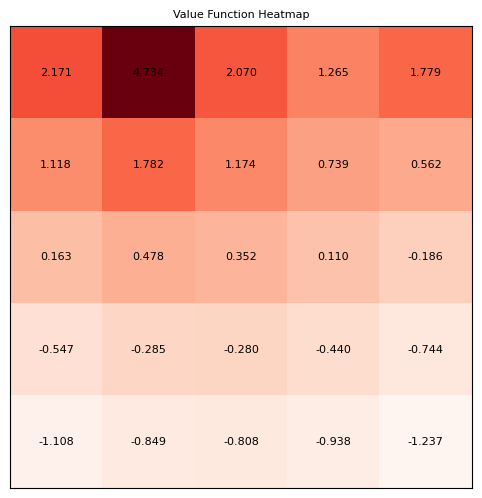

In [ ]:
# initialize value function
V = np.zeros((n, n))

# transition model and rewards
num_states = len(states)
P = np.zeros((num_states, num_states)) # transition matrix
R = np.zeros(num_states) # rewards vector

for state in states:
    id = state_id[state]
    
    if state in [blue, green]:
        R[id] = rewards[state]
        
        if state == blue:
            j = state_id[red]
            P[id][j] = 1.0
            continue
            
        elif state == green:
            j1 = state_id[yellow]
            j2 = state_id[red]
            P[id][j1] = 0.5
            P[id][j2] = 0.5
            continue
    
    # other states
    for x, y in actions:
        next_state = (state[0] + x, state[1] + y)
        
        # check boundaries
        if not (0 <= next_state[0] < n and 0 <= next_state[1] < n):
            next_state = state
            reward = -0.5  # penalty for leaving grid
        else:
            reward = 0
        
        j = state_id[next_state]
        P[id][j] += action_prob
        R[id] += action_prob * reward
        
        
# solve for the value function
I = np.eye(num_states)
V = np.linalg.solve(I - reward_discount * P, R).reshape((n, n)) 

print("Value Function:")
print(np.round(V, 2))

plot_value_function(V, 'Value Function Heatmap')

##### **ii. Iterartive Policy Evaluation**

Value Function after Iterative Policy Evaluation:
[[ 2.17  4.73  2.07  1.27  1.78]
 [ 1.12  1.78  1.17  0.74  0.56]
 [ 0.16  0.48  0.35  0.11 -0.19]
 [-0.55 -0.28 -0.28 -0.44 -0.74]
 [-1.11 -0.85 -0.81 -0.94 -1.24]]


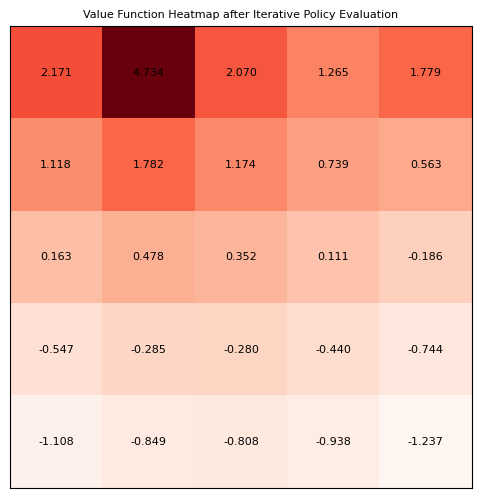

In [ ]:
# threshold for convergence
theta = 1e-5 

# initialize value function
V_iter = np.zeros((n, n))

# update value function until convergence
while True:
    delta = 0
    V_new = V_iter.copy()
    
    for i in range(n):
        for j in range(n):
            state = (i, j)
            
            # special states
            if state == blue:
                V_new[i][j] = rewards[blue] + reward_discount * V_iter[red]  # transition to red
                continue
            
            elif state == green:
                V_new[i][j] = 0.5 * (rewards[green] + reward_discount * V_iter[yellow]) + 0.5 * (rewards[green] + reward_discount * V_iter[red])
                continue
            
            # other states
            v = 0
            
            for x, y in actions:
                ni, nj = i + x, j + y # next state indices
                
                if ni < 0 or ni >= n or nj < 0 or nj >= n:
                    reward = -0.5 # penalty for leaving grid
                    ni, nj = i, j
                
                else:    
                    reward = 0
                
                # calculate value for this action
                v += action_prob * (reward + reward_discount * V_iter[ni][nj])
                
            V_new[i][j] = v
            
            # update delta for convergence check
            delta = max(delta, abs(V_iter[i][j] - V_new[i][j]))
            
    V_iter = V_new.copy()
    
    # stop if value function has converged
    if delta < theta:
        break
    
print("Value Function after Iterative Policy Evaluation:")
print(np.round(V_iter, 2))

plot_value_function(V_iter, 'Value Function Heatmap after Iterative Policy Evaluation')

#### **Determine Optimal Policy**

##### **i. Bellman Optimality Equation**


Bellman Optimal Policy:

Bellman Optimal Policy with Action Symbols:


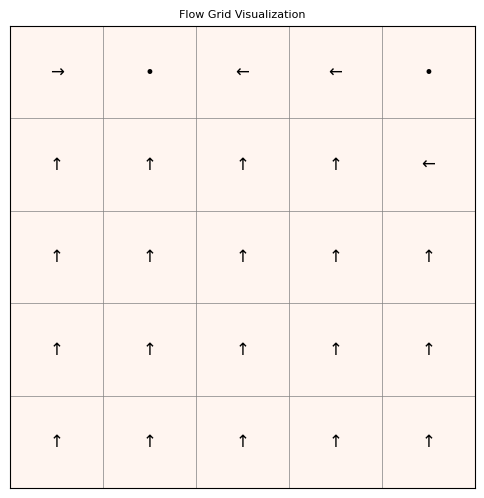


State Values:
[[20.997 22.102 20.997 19.947 18.382]
 [19.947 20.997 19.947 18.95  18.002]
 [18.95  19.947 18.95  18.002 17.102]
 [18.002 18.95  18.002 17.102 16.247]
 [17.102 18.002 17.102 16.247 15.435]]

Optimal State: Blue with value 22.1021


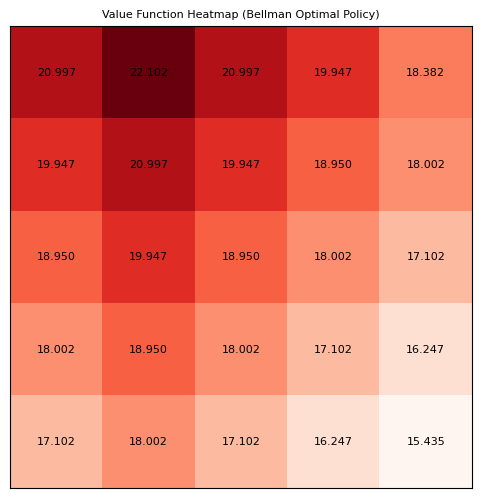

In [ ]:
# calculate q-values
def get_q_values(V, i, j):
    q_values = []
    for dx, dy in actions:
        ni, nj = i + dx, j + dy
        # if out of bounds reward is -0.5 and stay in place otherwise reward is 0
        reward = -0.5 if not (0 <= ni < n and 0 <= nj < n) else 0
        
        if not (0 <= ni < n and 0 <= nj < n):
            ni, nj = i, j  # stay in place

        q = reward + reward_discount * V[ni, nj]
        q_values.append(q)
    return q_values

def bellman_optimality_step(V):
    new_V = np.zeros_like(V)
    for i in range(n):
        for j in range(n):
            s = (i, j)
            
            # special states
            if s == blue:
                new_V[i, j] = 5 + reward_discount * V[red]
            elif s == green:
                next_val = 0.5 * (V[red] + V[yellow])
                new_V[i, j] = 2.5 + reward_discount * next_val
            # other states
            else:
                q_values = get_q_values(V, i, j)
                new_V[i, j] = max(q_values)
    return new_V

# solve value iteration
def solve_value_iteration(tol=1e-4):
    V = np.zeros((n, n)) # initialize value function
    
    # iterate until convergence
    while True:
        new_V = bellman_optimality_step(V)
        if np.max(np.abs(new_V - V)) < tol:
            break
        V = new_V

    # derive the policy
    policy = np.zeros((n, n), dtype=int)
    for i in range(n):
        for j in range(n):
            if (i, j) == blue or (i, j) == green:
                continue
            q_values = get_q_values(V, i, j)
            best_action = np.argmax(q_values)
            policy[i, j] = best_action
            
    return policy, V

bell_policy, bell_V = solve_value_iteration()
print_results(bell_V, bell_policy, 'Bellman Optimal Policy')

##### **ii. Policy Iteration**

In [ ]:
def one_step_lookahead(V, state):
    i, j = state
    q_values = []
    for a, (di, dj) in enumerate(actions):
        ni, nj = i + di, j + dj
        if not in_grid(ni, nj):
            ni, nj = i, j
            reward = -0.5
        else:
            reward = 0

        next_v = V[ni, nj] # value of next state

        if state == blue:
            reward = 5
            next_v = V[red]
        elif state == green:
            reward = 2.5
            next_v = 0.5 * (V[red] + V[yellow])
        
        # calculate q-value
        q_values.append(reward + reward_discount * next_v)
    return q_values


Policy Iteration:

Policy Iteration with Action Symbols:


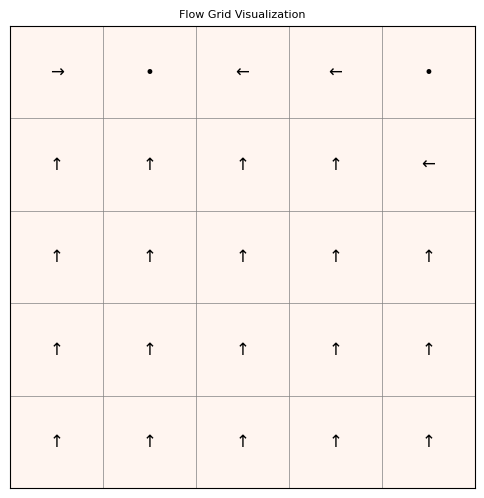


State Values:
[[20.997 22.102 20.997 19.947 18.383]
 [19.947 20.997 19.947 18.95  18.002]
 [18.95  19.947 18.95  18.002 17.102]
 [18.002 18.95  18.002 17.102 16.247]
 [17.102 18.002 17.102 16.247 15.435]]

Optimal State: Blue with value 22.1023


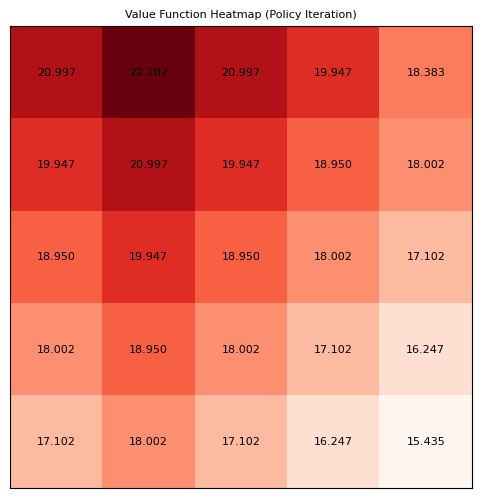

In [ ]:
def policy_iteration():
    policy = np.random.choice(len(actions), size=(n, n)) # initialize random policy
    V = np.zeros((n, n)) # initialize value function

    while True:
        # Policy Evaluation
        while True:
            delta = 0
            new_V = np.copy(V)
            for i in range(n):
                for j in range(n):
                    s = (i, j)
                    a = policy[i, j]
                    di, dj = actions[a]
                    ni, nj = i + di, j + dj
                    
                    # boundary check
                    if not in_grid(ni, nj):
                        ni, nj = i, j
                        reward = -0.5
                    else:
                        reward = 0

                    next_v = V[ni, nj]

                    if s == blue:
                        reward = 5
                        next_v = V[red]
                    elif s == green:
                        reward = 2.5
                        next_v = 0.5 * (V[red] + V[yellow])
                        
                    # update value function
                    new_V[i, j] = reward + reward_discount * next_v
                    
                    # update delta for convergence check
                    delta = max(delta, abs(V[i, j] - new_V[i, j]))
                    
            V = new_V
            
            # stop if value function has converged
            if delta < 1e-4:
                break

        # Policy Improvement
        policy_stable = True # check if policy is stable
        for i in range(n):
            for j in range(n):
                s = (i, j)
                old_action = policy[i, j]
                
                # look ahead to get best action under current V
                q_values = one_step_lookahead(V, s)
                policy[i, j] = np.argmax(q_values)
                
                # check if policy has changed
                if old_action != policy[i, j]:
                    policy_stable = False

        # stop if policy is stable
        if policy_stable:
            break

    return policy, V

pi_policy, V_pi = policy_iteration()

print_results(V_pi, pi_policy, 'Policy Iteration')

##### **iii. Policy Improvement With Value Iteration**


Value Iteration:

Value Iteration with Action Symbols:


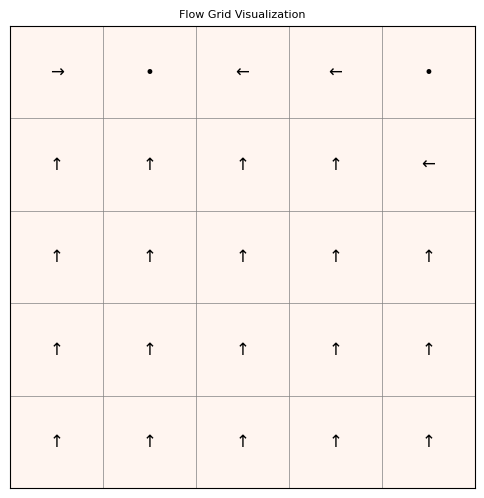


State Values:
[[20.997 22.102 20.997 19.947 18.382]
 [19.947 20.997 19.947 18.95  18.002]
 [18.95  19.947 18.95  18.002 17.102]
 [18.002 18.95  18.002 17.102 16.247]
 [17.102 18.002 17.102 16.247 15.435]]

Optimal State: Blue with value 22.1021


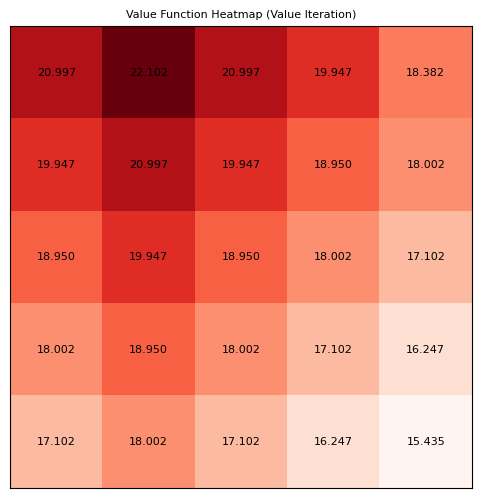

In [ ]:
def value_iteration():
    V = np.zeros((n, n)) # initialize value function
    
    while True:
        delta = 0
        new_V = np.copy(V)
        
        for i in range(n):
            for j in range(n):
                s = (i, j)
                
                # compute q-values for all actions
                q_values = one_step_lookahead(V, s)
                
                # apply Bellman optimality update
                new_V[i, j] = max(q_values)
                
                # track maximum change for convergence
                delta = max(delta, abs(V[i, j] - new_V[i, j]))
        V = new_V
        
        # stop if value function has converged
        if delta < 1e-4:
            break

    # extract policy
    policy = np.zeros((n, n), dtype=int)
    
    for i in range(n):
        for j in range(n):
            q_values = one_step_lookahead(V, (i, j))
            policy[i, j] = np.argmax(q_values) # best action
    return policy, V

policy_vi, V_vi = value_iteration()

print_results(V_vi, policy_vi, 'Value Iteration')

### **Part 2**

In [ ]:
# update new_red position
new_red = (4, 2)

#### **Monte Carlo Methods**

In [ ]:
def get_ns_reward(state, action):
    # get the next state and reward given a current state and an action
    
    i, j = state
    di, dj = action
    
    # special states
    if state == blue:
        return new_red, 5
    elif state == green:
        return random.choice([new_red, yellow]), 2.5
    elif state in terminal_states:
        return state, 0
    
    ni, nj = i + di, j + dj
    
    # check boundaries
    if not in_grid(ni, nj):
        return (i, j), -0.5
    
    return (ni, nj), -0.2

def policy_action(policy, state, eps):
    if random.random() < (1 - eps):
        return policy[state_id[state]] # exploit
    return random.choice(range(len(actions)))  # explore

def print_mc_results(V, policy, title):
    print(f"\n{title}:")
    
    policy_symbols = np.full((n, n), '', dtype=object)
    for i in range(n):
        for j in range(n):
            
            if (i, j) in terminal_states or (i, j) == blue or (i, j) == green:
                policy_symbols[i, j] = f'•'
            else:
                policy_symbols[i, j] = action_symbols[policy[i, j]]
    
    print(f"\n{title} with Action Symbols:")
    
    policy_np = np.array(policy_symbols)
    
    fig, ax = plt.subplots(figsize=(6, 6))
    
    ax.set_xticks(np.arange(n + 1) - 0.5, minor=False)
    ax.set_yticks(np.arange(n + 1) - 0.5, minor=False)
    ax.grid(True, which='major', color='grey', linestyle='-', linewidth=0.5)
    
    ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
    
    for i in range(n):
        for j in range(n):
            if (n - 1 - i, j) in terminal_states:                
                color = 'black'
            else:
                color = "#FFF5F0"
                
            rect = patches.Rectangle((j - 0.5, n - 1 - i - 0.5), 1, 1,
                                    linewidth=1, edgecolor='none', facecolor=color)
            ax.add_patch(rect)
            ax.text(j, n - 1 - i, policy_np[(n - 1 - i), j],
                    ha='center', va='center', fontsize=12, color='black')

    ax.set_xlim(-0.5, n - 0.5)
    ax.set_ylim(-0.5, n - 0.5)
    ax.set_title("Flow Grid Visualization", fontsize=8)
    plt.gca().invert_yaxis()
    plt.show()
    
    optimal_state = np.unravel_index(np.argmax(V), V.shape)
    
    if optimal_state == (0, 1):
        os = 'Blue'
    elif optimal_state == (0, 4):
        os = 'Green'
    else:
        os = f'State {optimal_state}'
        
    print("\nState Values:")
    print(np.round(V, 3))
    
    print(f"\nOptimal State: {os} with value {V[optimal_state]:.4f}")
    
    plot_value_function(V, f'Value Function Heatmap ({title})')

##### **i. Exploring Starts**

In [ ]:
def exp_starts(num_episodes=5000):
    np.random.seed(42)
    random.seed(131)
    
    Q = np.zeros((len(states), len(actions)))  # action-value function
    returns = {state: {a: [] for a in range(len(actions))} for state in states} # returns for each state-action pair
    policy = np.random.choice(len(actions), size=len(states))  # random initial policy

    for episode in range(num_episodes):
        state = random.choice(states)  # exploring starts
        trajectory = []
        
        while True:
            action = random.choice(range(len(actions))) # equiprobable action selection
            next_state, reward = get_ns_reward(state, actions[action])
            trajectory.append((state, action, reward))
            
            if next_state in terminal_states:
                break # end episode
            
            state = next_state
        
        G = 0 # initialize return
        visited = set() # track visited state-action pairs
        
        # iterate through the trajectory in reverse to calculate returns and update Q
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = reward + reward_discount * G # discounted return
            key = (state, action)
            
            if key in visited:
                continue # already visited
            
            visited.add(key)
            
            # update returns and Q-values
            returns[state][action].append(G)
            Q[state_id[state]][action] = np.mean(returns[state][action])
            
            # update policy greedily
            policy[state_id[state]] = np.argmax(Q[state_id[state]])
    
    return policy, Q


Exploring Starts Policy:

Exploring Starts Policy with Action Symbols:


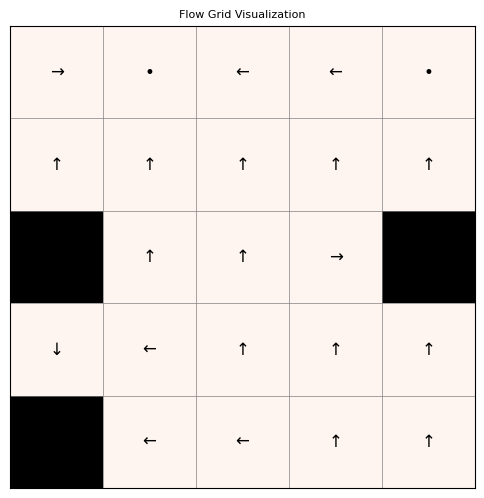


State Values:
[[ 2.648  3.062  2.715  0.184  0.386]
 [ 0.673  2.673  0.212 -0.46   0.009]
 [ 0.    -0.008 -0.594 -0.2    0.   ]
 [-0.2   -0.82  -1.172 -1.112 -0.2  ]
 [ 0.    -0.2   -1.266 -1.634 -1.327]]

Optimal State: Blue with value 3.0621


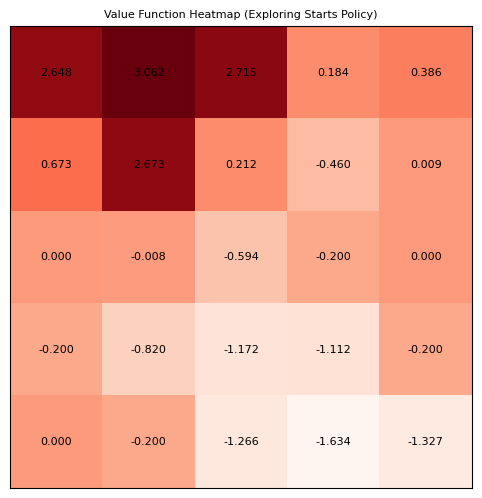

In [125]:
exp_policy, exp_Q = exp_starts(num_episodes=10000)
exp_sv = np.max(exp_Q, axis=1).reshape((n, n))
print_mc_results(exp_sv, np.array(exp_policy).reshape((n, n)), 'Exploring Starts Policy')

##### **ii. Epsilon Soft**

In [ ]:
def eps_soft(start_state, num_episodes=10000, eps=0.05):
    np.random.seed(42)
    random.seed(42)
    
    Q = np.zeros((len(states), len(actions)))  # action-value function
    returns = {state: {a: [] for a in range(len(actions))} for state in states} # returns for each state-action pair
    policy = np.random.choice(len(actions), size=len(states))  # random initial policy

    for episode in range(num_episodes):
        state = start_state # fixed start state
        action = policy_action(policy, state, eps=eps) # choose action based on e-soft policy
        trajectory = []
        
        while True:
            next_state, reward = get_ns_reward(state, actions[action])
            trajectory.append((state, action, reward))
            
            if next_state in terminal_states:
                break
            
            state = next_state
            action = policy_action(policy, state, eps=eps)
        
        G = 0 # initialize return
        visited = set() # track visited state-action pairs
        
        # iterate through the trajectory in reverse to calculate returns and update Q
        for t in reversed(range(len(trajectory))):
            state, action, reward = trajectory[t]
            G = reward + reward_discount * G # discounted return
            
            if (state, action) in visited:
                continue # already visited
            
            visited.add((state, action))
            returns[state][action].append(G)
            
            # update Q-values with mean of returns
            Q[state_id[state]][action] = np.mean(returns[state][action])
            
            # eps-soft policy update
            best_action = np.argmax(Q[state_id[state]]) # get best action
            
            # build probability distribution
            prob = np.ones(len(actions)) * (eps / len(actions))
            prob[best_action] += 1 - eps # probability of best action
            
            # sample action from the distribution
            policy[state_id[state]] = np.random.choice(len(actions), p=prob)
    
    return policy, Q


Epsilon-Soft Policy:

Epsilon-Soft Policy with Action Symbols:


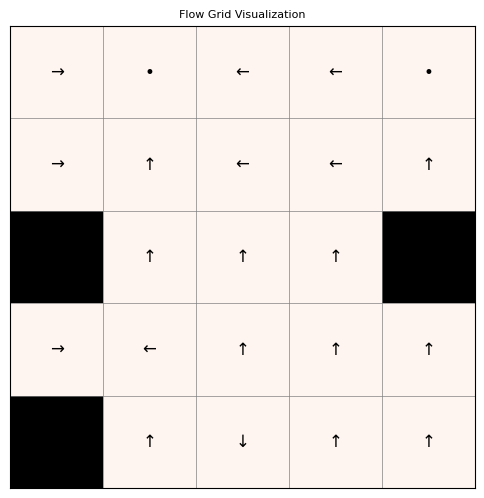


State Values:
[[ 2.082  3.598  3.039  2.607  1.634]
 [ 2.474  2.535  2.354  2.008  1.313]
 [ 0.     1.567  1.341  1.495  0.   ]
 [ 0.721  0.597  0.47   0.977 -0.2  ]
 [ 0.    -0.199 -0.588  0.086 -0.59 ]]

Optimal State: Blue with value 3.5978


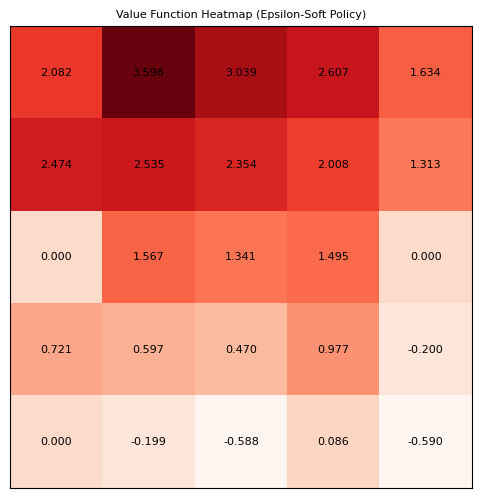

In [81]:
eps_policy, Q_eps = eps_soft(start_state=(3, 3), eps=0.1)
eps_sv = np.max(Q_eps, axis=1).reshape((n, n))
print_mc_results(eps_sv, np.array(eps_policy).reshape((n, n)), 'Epsilon-Soft Policy')

#### **Off-Policy Control**

In [ ]:
def off_policy(start_state, episodes=10000):
    random.seed(42)
    np.random.seed(42)
    
    Q = np.zeros((len(states), len(actions))) # action-value function
    C = np.zeros((len(states), len(actions))) # cumulative weights
    policy = np.random.choice(len(actions), size=len(states))  # greedy policy

    for episode in range(episodes):
        s = start_state
        trajectory = []

        # generate episode using the behavior policy (uniform random)
        while True:
            a = random.choice(range(len(actions)))  # equiprobable behavior policy
            next_s, r = get_ns_reward(s, actions[a])
            trajectory.append((s, a, r))
            if next_s in terminal_states:
                break
            s = next_s

        G = 0 # initialize return
        W = 1.0 # importance weight

        for t in reversed(range(len(trajectory))):
            s, a, r = trajectory[t]
            s_idx = state_id[s]

            G = reward_discount * G + r # discounted return
            
            # update cumulative weights and Q-values
            C[s_idx, a] += W
            Q[s_idx, a] += (W / C[s_idx, a]) * (G - Q[s_idx, a])
            
            # update target policy greedily
            best_a = np.argmax(Q[s_idx])
            policy[s_idx] = best_a

            # delayed importance weights for first 1000 episodes
            if episode < 1000:
                rho = 1.0
            else:
                # calculate importance weight
                best_a = np.argmax(Q[s_idx])
                rho = 1.0 / 0.25 if a == best_a else 0.0
                
                # stop undate if action is not greedy
                if rho == 0:
                    break
                
                W *= rho # update importance weight

    # compute V(s)
    V = np.zeros((n, n))
    grid_policy = np.zeros((n, n), dtype=int)

    for s, (i, j) in enumerate(states):
        V[i, j] = np.max(Q[s])
        grid_policy[i, j] = policy[s] # get best action under learned policy

    return V, grid_policy



MC Off-Policy (Importance Sampling):

MC Off-Policy (Importance Sampling) with Action Symbols:


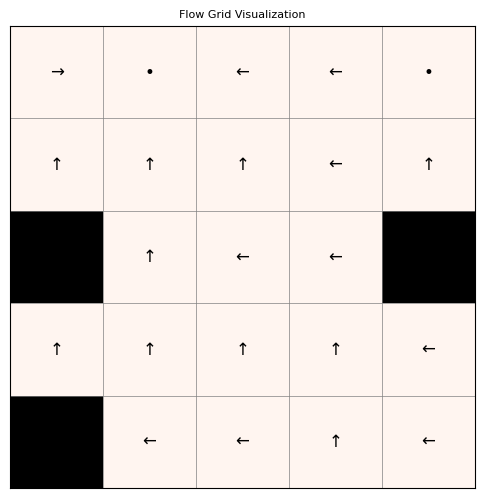


State Values:
[[ 4.075  4.488  4.067  3.225  1.968]
 [ 3.512  4.088  3.543  3.048  1.637]
 [ 0.     3.537  3.165  2.897  0.   ]
 [-0.2    2.487  2.356  2.284  0.705]
 [ 0.    -0.2   -0.506  2.32   2.021]]

Optimal State: Blue with value 4.4877


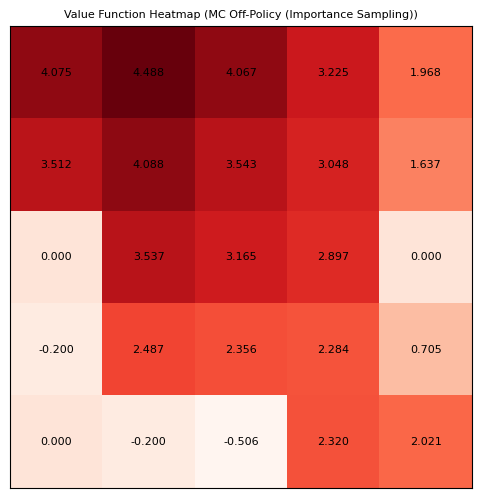

In [73]:
V, learned_policy = off_policy(start_state=(3, 2))
print_mc_results(V, learned_policy, title="MC Off-Policy (Importance Sampling)")